In [1]:
from backend import *
from tqdm.notebook import tqdm
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

# Preprocessing Earthquake probabilities

In [49]:
# Creating the DataFrame of the earthquakes' probabilities
#df = pd.read_table('../incremental_annual_rates/incremental_annual_rates_USA.txt', sep='\s+', header=None)
df = pd.read_table('/home/mogyi/Projects/FRADIR/PSRLG_JSAC2020_toMogyi/seismic_data/incremental_annual_rates/incremental_annual_rates_italy.txt', sep='\s+', header=None)

df.columns = ['Long', 'Lat'] + [str(np.around(x,1)) for x in np.arange(4.6, 8.2, 0.1)]
#df.drop(df.columns[42:], axis=1, inplace=True)
df.fillna(value=0.0, inplace=True)
df = df[df['4.6'] != 0.0]

#df.to_csv('incremental_annual_rates/incremental_annual_rates_italy_without_zeros.csv', index=False)

In [50]:
pd.options.display.float_format = '{:,.10f}'.format

In [51]:
df.head()

,Long,Lat,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,...,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1
1400,10.8000000000,48.3000000000,0.0000000006,0.0000000004,0.0000000003,0.0000000003,0.0000000002,0.0000000002,0.0000000001,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1401,10.8500000000,48.3000000000,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1402,10.9000000000,48.3000000000,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1403,10.9500000000,48.3000000000,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000003,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1404,11.0000000000,48.3000000000,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [ ]:
df = pd.read_csv('../incremental_annual_rates/incremental_annual_rates_USA.csv')
df.describe()

In [6]:
df = df[df['4.6'] != 0.0]

In [12]:
# Delete If no earthquake exist with such magnitude
df.drop(labels=['8.5', '8.6'], axis=1, inplace=True)

In [52]:
# Convert the rates to probabilities
prob_matrix = df.drop(['Lat', 'Long'], axis=1).to_numpy()
scale = prob_matrix.sum()
print(scale)
df.iloc[:,2:] = df.iloc[:,2:] / scale

#df.to_csv('earthquake_probabilities/italy_short.csv', index=False)

5.5384342731352865


In [53]:
df.to_csv('earthquake_probabilities/italy.csv', index=False)

In [54]:
len(df)

48442

In [97]:
df = pd.read_csv('earthquake_probabilities/italy.csv')

In [67]:
# Downsample the eartquakes
res = 10
ds = df.copy()
ds['Lat'] = (ds['Lat']*res).astype(int)
ds['Long'] = (ds['Long']*res).astype(int)
ds = ds.groupby(['Long','Lat'], as_index=False).sum()
ds['Lat'] = ds['Lat']/res
ds['Long'] = ds['Long']/res

print(f'Original number of eartquakes: {len(df)}')
print(f'Downsampled number of eartquakes: {len(ds)}')
print(f'Ratio: {len(df)/len(ds):.2f}')
ds.head()


Original number of eartquakes: 48442
Downsampled number of eartquakes: 12307
Ratio: 3.94


,Long,Lat,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,...,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1
0,5.0000000000,45.1000000000,0.0000000001,0.0000000001,0.0000000001,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,5.0000000000,45.2000000000,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000002,0.0000000001,0.0000000001,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,5.0000000000,45.3000000000,0.0000000008,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,0.0000000001,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
3,5.0000000000,45.4000000000,0.0000000009,0.0000000007,0.0000000006,0.0000000005,0.0000000004,0.0000000003,0.0000000002,0.0000000002,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
4,5.0000000000,45.5000000000,0.0000000009,0.0000000007,0.0000000006,0.0000000004,0.0000000004,0.0000000003,0.0000000002,0.0000000002,...,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000


In [99]:
ds['4.6'].sum()

0.20025143023418376

In [100]:
df['4.6'].sum()

0.20025143023418376

In [43]:
ds.to_csv('earthquake_probabilities/italy_ds16.csv', index=False)

# Preprocessing the network

In [2]:
g1 = nx.read_gml('networks/italy_withLength.gml', label='id')
g2 = read_lgf_to_networkx_extended('../spine/solution_italia_tmit-bme_long-lat_cost3_minAvailWPreq0-99500.lgf')

In [14]:
g1.edges[(0, 1, 0)]

{'id': 26,
 'points': {'point': [{'Longitude': 14.20283, 'Latitude': 42.4584},
   {'Longitude': 13.874160827302958, 'Latitude': 42.18977106249462},
   {'Longitude': 13.805968688165303, 'Latitude': 42.07149971380834},
   {'Longitude': 13.5743519519844, 'Latitude': 41.951316788885684},
   {'Longitude': 13.5743519519844, 'Latitude': 42.241028060235635},
   {'Longitude': 13.425204752600411, 'Latitude': 42.367036702622485},
   {'Longitude': 13.016076136662997, 'Latitude': 42.40828181839583},
   {'Longitude': 12.745492328371324, 'Latitude': 41.89193},
   {'Longitude': 12.51133, 'Latitude': 41.89193}]},
 'length': 243.7782466405945}

In [15]:
g2.edges[(0, 1, 0)]

{'points': {'point': [{'Longitude': 14.20283, 'Latitude': 42.4584},
   {'Longitude': 13.874160827302958, 'Latitude': 42.18977106249462},
   {'Longitude': 13.805968688165303, 'Latitude': 42.07149971380834},
   {'Longitude': 13.5743519519844, 'Latitude': 41.951316788885684},
   {'Longitude': 13.5743519519844, 'Latitude': 42.241028060235635},
   {'Longitude': 13.425204752600411, 'Latitude': 42.367036702622485},
   {'Longitude': 13.016076136662997, 'Latitude': 42.40828181839583},
   {'Longitude': 12.745492328371324, 'Latitude': 41.89193},
   {'Longitude': 12.51133, 'Latitude': 41.89193}]},
 'length': 243.7782466405945,
 'onspine': 1,
 'unav1': 0.0014855403,
 'unav': 0.0014855403}

In [13]:
for e in g2.edges:
    g2.edges[e]['points'] = g1.edges[e]['points']

In [16]:
nx.write_gml(g2, 'networks/italy_995.gml')
write_networkx_to_lgf(g2, 'networks/italy_995.lgf')

In [ ]:
EARTH_RADIUS = 6371

g = nx.read_gml('networks/interoute_v2_feri.gml', label='id')
edge = (2, 5, 0)

for n in g.nodes:
    u = node_to_SVector(g.nodes[n])
    v,w = edge_to_SVectors(g.edges[edge])
    gomb = int(u.distance_to_section(v,w) * EARTH_RADIUS)
    
    edge_points = [tuple(p.values()) for p in g.edges[edge]['points']['point']]
    l = LineString(edge_points)
    p = Point(g.nodes[n]['Longitude'], g.nodes[n]['Latitude'])
    nearest_point = nearest_points(l, p)[0].coords[0]
    R = distance(lonlat(*(g.nodes[n]['Longitude'], g.nodes[n]['Latitude'])), lonlat(*nearest_point)).km
    print(f'{(gomb-R)/(R+1):.2f}')

# Earthquake intensity calculation

In [19]:
g = nx.read_gml('networks/italy_995.gml', label='id')

df = pd.read_csv('earthquake_probabilities/italy_ds16.csv')
df.insert(loc=0, column='Epicenter', value=list(zip(df.Long, df.Lat)))
df.set_index('Epicenter', inplace=True)
df.drop(['Lat', 'Long'], axis=1, inplace=True)

epicenters = df.index
magnitudes = df.columns

In [45]:
epicenters[:2]

Index([(5.1, 45.1), (5.1, 45.3)], dtype='object', name='Epicenter')

In [20]:
EARTH_RADIUS = 6371
I1= np.ones((g.number_of_edges(), len(epicenters), len(magnitudes)))
I2 = np.ones((g.number_of_edges(), len(epicenters), len(magnitudes)))

D1 = np.ones((g.number_of_edges(), len(epicenters)))
D2 = np.ones((g.number_of_edges(), len(epicenters)))

for i, e in tqdm(enumerate(g.edges), total=g.number_of_edges()):
    edge_points = [(p['Longitude'], p['Latitude']) for p in g.edges[e]['points']['point']]
    l = LineString(edge_points)
    v,w = edge_to_SVectors(g.edges[e])
    for j, epicenter in enumerate(epicenters):
        p = Point(epicenter[0],epicenter[1])
        nearest_point = nearest_points(l, p)[0].coords[0]
        # print([o.wkt for o in nearest_points(l, p)])
        
        R1 = distance(lonlat(*epicenter), lonlat(*nearest_point)).km
        
        u = SVector(epicenter[1],epicenter[0])
        R2 = u.distance_to_section(v,w) * EARTH_RADIUS
        #print(i, e,R1, R2)
        
        D1[i,j] = R1
        D2[i,j] = R2


for k, M in enumerate(magnitudes):
    i1 = intensity_europe(np.float(M), D1)
    i1[i1<1.] = 1.
    i2 = intensity_europe(np.float(M), D2)
    i2[i2<1.] = 1.
    I1[:,:,k] = i1
    I2[:,:,k] = i2

In [32]:
I3 = np.ones((g.number_of_edges(), len(df.index), len(df.columns)))
for k, M in enumerate(df.columns):
    i = intensity_europe(np.float(M), D1-1.5)
    i[i<1.] = 1.
    I3[:,:,k] = i

(array([  105.,   191.,   891.,   651.,   539.,   582.,  2329.,  2500.,
         4104.,  3555.,  3168.,  3299.,  4839.,  4687.,  6640.,  8969.,
        60098.,  3457.,   496.,   165.]),
 array([-344.51186152, -323.97574358, -303.43962564, -282.9035077 ,
        -262.36738976, -241.83127182, -221.29515387, -200.75903593,
        -180.22291799, -159.68680005, -139.15068211, -118.61456417,
         -98.07844623,  -77.54232829,  -57.00621035,  -36.47009241,
         -15.93397447,    4.60214347,   25.13826141,   45.67437936,
          66.2104973 ]),
 <BarContainer object of 20 artists>)

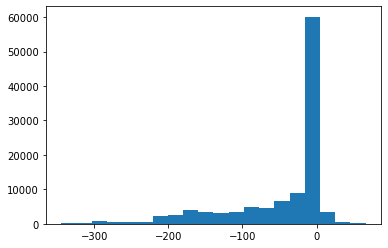

In [21]:
import matplotlib.pyplot as plt

diff = ((D1 - D2)).flatten()

plt.hist(diff, 20)

In [34]:
np.save('intensities/italy_ds16.npy', I1)
#np.save('intensities/italy_ds16_csak.npy', I2)

# SRLG collection

In [37]:
min_cut_srlgs = get_minimal_cut_SRLGs('PSRLGs/italy_995.xml', g)
len(min_cut_srlgs)

356

In [52]:
srlgs = [srlg for srlg in min_cut_srlgs if get_SRLG_probability(srlg,g,I1,H,prob_matrix) > 0.0001]

In [53]:
len(srlgs)

85

In [ ]:
 for srlg in srlgs:
    print(get_SRLG_probability(srlg,g,I1,H,prob_matrix), srlg)
#print(get_probability_of_falling_apart(srlgs,g,I1,H,prob_matrix))

In [26]:
# The network
g = nx.read_gml('networks/italy_995.gml', label="id")
L = len(g.edges)
links = range(L)

# The matrix of the intensity values, dimensions: [L,P,M] (link, position, magnitude)
#I1 = np.load('intensities/italy_ds16.npy')
#I2 = np.load('intensities/italy_ds16_csak.npy')

# The matrix of earthquake probabilities, dimensions: [P,M] (position, magnitude)
prob_matrix = pd.read_csv('earthquake_probabilities/italy_ds16.csv').drop(['Lat', 'Long'], axis=1).to_numpy()
P, M = prob_matrix.shape
epicenters = range(P)
magnitudes = range(M)

srlgs, srlg_probs = get_SRLGs('PSRLGs/italy_995.xml')


In [33]:
H = np.ones(L) * 6.
#for T in np.concatenate((np.arange(0.01, 0.001, -0.001), np.arange(0.001, 0.0007, -0.0001))):
for T in [0.003]:
    print(f'=====================\n{T:.4f}')
    for i in range(len(srlgs)):
        if srlg_probs[i] > T:
            print(f'{srlg_probs[i]:.4f}, {get_SRLG_probability(srlgs[i],g,I1,H,prob_matrix):.4f}, {get_SRLG_probability(srlgs[i],g,I3,H,prob_matrix):.4f}, {srlgs[i]}')

0.0030
0.0134, 0.0071, 0.0084, {(17, 23, 0)}
0.0042, 0.0029, 0.0035, {(17, 22, 0)}
0.0044, 0.0042, 0.0049, {(15, 22, 0)}
0.0030, 0.0034, 0.0040, {(8, 16, 0)}
0.0073, 0.0075, 0.0089, {(8, 15, 0)}
0.0032, 0.0028, 0.0034, {(9, 12, 0)}
0.0065, 0.0073, 0.0085, {(7, 8, 0)}
0.0178, 0.0171, 0.0209, {(1, 8, 0)}
0.0032, 0.0028, 0.0033, {(9, 10, 0)}
0.0057, 0.0039, 0.0049, {(6, 9, 0)}
0.0050, 0.0036, 0.0043, {(6, 7, 0)}
0.0201, 0.0207, 0.0233, {(0, 7, 0)}
0.0033, 0.0030, 0.0035, {(6, 20, 0)}
0.0186, 0.0136, 0.0159, {(0, 1, 0)}
0.0106, 0.0065, 0.0079, {(1, 2, 0)}
0.0057, 0.0052, 0.0058, {(0, 24, 0)}
0.0079, 0.0089, 0.0099, {(2, 24, 0)}
0.0218, 0.0176, 0.0215, {(18, 24, 0)}
0.0076, 0.0040, 0.0044, {(18, 24, 0), (2, 18, 0)}
0.0245, 0.0171, 0.0197, {(2, 18, 0)}
0.0038, 0.0042, 0.0045, {(3, 18, 0), (4, 18, 0)}
0.0183, 0.0146, 0.0166, {(4, 18, 0)}
0.0109, 0.0111, 0.0126, {(3, 18, 0)}
0.0138, 0.0068, 0.0083, {(3, 5, 0)}


In [54]:
# Correcting node order in SRLG edges
edge_list = list(g.edges)
for idx,srlg in enumerate(srlgs):
    for l in srlg:
        if l not in edge_list:
            srlgs[idx].discard(l)
            srlgs[idx].add((l[1],l[0],l[2]))

In [55]:
# Write
with open('min_cut_SRLGs/italy_995_10-4', 'wb') as fp:
    pickle.dump(srlgs, fp)

# Read
#with open ('min_cut_SRLGs/italy', 'rb') as fp:
#    cut_srlgs = pickle.load(fp)

# Creating SRG file

In [9]:
g = read_lgf_to_networkx_extended('networks/usa_99.lgf')

with open ('results/Heuristic_upgraded_edges_usa_99_nospine', 'rb') as fp:
    cut_srlgs = pickle.load(fp)

In [48]:
write_networkx_to_srg('networks/italy_995.srg', g, srlgs)

0

# Modify SRG file

In [2]:
import glob

In [4]:
for srg_file in glob.glob('./results/usa_99/*.srg'):
    if 'ILP' in srg_file:
        g, srlgs = read_lgf_to_networkx_extended(srg_file)
        write_networkx_to_srg(srg_file, g, srlgs)